# Introduction to Data Science - Lab 9
*CS 5963 / MATH 3900, University of Utah, http://datasciencecourse.net/* 

In this lab we will explore how we can extract data from web-APIs. The first part of this tutorial is based on [this blog](https://www.dataquest.io/blog/python-api-tutorial/).

API stands for Application Programming Interface. It is supposed to be a **well defined interface** for consuming data, or, more generally, for the **interaction with a remote program** on a server. APIs aren't only generated so that you can read data; they're often designed so that you could write custom software to interact with the API. You could, for example, write your own twitter client! 

APIs are usually well documented, as the organization that provides APIs wants you to use them. 

Here are a couple of examples of sites that have documented APIs:

 * [StackExchange](https://api.stackexchange.com/docs)  
 * [Twitter](https://dev.twitter.com/rest/public)
 * [Facebook](https://developers.facebook.com/docs/graph-api)
 * [KEGG](http://www.genome.jp/kegg/rest/keggapi.html) 
 * [Google Maps](https://developers.google.com/maps/) 
 * and many many more. 
 
Most APIs require some form of authentication and have rules on what you're allowed to do and what not. Follow those rules, you will be blocked faster than you can say GET if you don't. 
 
An API works a lot like working with a website, but instead of a human in front of the screen, it's computers talking to each other. 

We'll be using the dominant form of APIs, REST (REpresentational State Transfer), which are now the dominant way of exposing and API on the web. REST APIs use a [URI](https://en.wikipedia.org/wiki/Uniform_Resource_Identifier) (a Uniform Resource Identifier; URLs are one specific form of URIs) to specify what you want to do with and API.

All API methods in REST are relative to a base URL. E.g., for twitter this would be `https://api.twitter.com/1.1/`, a query would look like this: `https://api.twitter.com/1.1/search/tweets.json?q=%40twitterapi`.

REST APIs can return data in different forms, the most common ones are JSON and XML, and of those two, JSON is now dominant. JSON stands for JavaScript Object Notation, and is a pretty convenient format, as we'll see. 
 

Let's start with a very simple example, retrieving the current position of the ISS. We will be using the [requests library](http://www.python-requests.org/en/latest/), which will handle our communication with the server.

In [1]:
import requests 
# Make a get request to get the latest position of the international space station from the opennotify api.
response = requests.get("http://api.open-notify.org/iss-now.json")

response

<Response [200]>

That looks good, we've received a response and it has status 200. What does the 200 mean? It's a status code - you've probably seen the "Error 404" on the internet. 

Here are a couple of codes:

 * 200 – everything went okay, and the result has been returned (if any)
 * 301 – the server is redirecting you to a different endpoint. This can happen when a company switches domain names, or an endpoint name is changed.
 * 401 – the server thinks you’re not authenticated. This happens when you don’t send the right credentials to access an API (we’ll talk about authentication in a later post).
 * 400 – the server thinks you made a bad request. This can happen when you don’t send along the right data, among other things.
 * 403 – the resource you’re trying to access is forbidden – you don’t have the right permissions to see it.
 * 404 – the resource you tried to access wasn’t found on the server.

Let's try to get a response with a wrong URL:

In [2]:
response_failed = requests.get("http://api.open-notify.org/iss")

response_failed

<Response [400]>

We used the get methods to put in a GET request. There are four different types of requests: 

![Request types](requests.png)
[Source](https://en.wikipedia.org/wiki/Representational_state_transfer)

Let's look at the payload of our previous, successful response:

In [3]:
response.content

b'{\n  "iss_position": {\n    "latitude": 24.792154054967877, \n    "longitude": 94.16731265296721\n  }, \n  "message": "success", \n  "timestamp": 1475266882\n}\n'

We can already see that this is JSON (though as a `bytes` object), but we can check formally:

In [4]:
response.headers['content-type']

'application/json'

We can decode this byte object, then the JSON will be readable. 

In [5]:
response_j = response.content.decode("utf-8")
print(response_j)

{
  "iss_position": {
    "latitude": 24.792154054967877, 
    "longitude": 94.16731265296721
  }, 
  "message": "success", 
  "timestamp": 1475266882
}



Let's take a look at the JSON here:

```JSON
{
  "iss_position": {
    "latitude": -30.005751854107206, 
    "longitude": -104.20085371352678
  }, 
  "message": "success", 
  "timestamp": 1475240215
}
```

This looks a lot like a dictionary! We have key-value pairs. 

We can use the [json library](https://docs.python.org/3/library/json.html) to convert JSON into objects:

In [7]:
import json
response_d = json.loads(response_j)
print(type(response_d))
response_d

<class 'dict'>


{'iss_position': {'latitude': 24.792154054967877,
  'longitude': 94.16731265296721},
 'message': 'success',
 'timestamp': 1475266882}

Or we can use pandas data loading: 

In [8]:
import pandas as pd 

df = pd.read_json(response_j)
df

,iss_position,message,timestamp
latitude,24.792154,success,2016-09-30 20:21:22
longitude,94.167313,success,2016-09-30 20:21:22


This isn't quite what we want - we probably want one row per timestamp and longitude and latitude as columns:

In [9]:
def flatten(response_d):
    response_d["latitude"] = response_d["iss_position"]["latitude"]
    response_d["longitude"] = response_d["iss_position"]["longitude"]
    del(response_d["iss_position"])
    return response_d
flatten(response_d)

{'latitude': 24.792154054967877,
 'longitude': 94.16731265296721,
 'message': 'success',
 'timestamp': 1475266882}

That looks better. Let's get a couple of positions of the ISS over time and save it as an array:

In [10]:
import time

def pull_position():
    """Retreives the position of the ISS and returns it as a flat dictionary"""
    response = requests.get("http://api.open-notify.org/iss-now.json")
    response_j = response.content.decode("utf-8")
    response_d = json.loads(response_j)
    flat_response = flatten(response_d)
    return flat_response    

iss_position = []
    
# calls pull_position 10 times with 3 seconds break
for i in range(10):
    flat_response = pull_position()
    iss_position.append(flat_response)
    print(flat_response)
    time.sleep(3)
    
iss_position

{'timestamp': 1475266979, 'latitude': 20.166691892427295, 'longitude': 98.30652340321083, 'message': 'success'}
{'timestamp': 1475266982, 'latitude': 20.01535880608191, 'longitude': 98.4353134502006, 'message': 'success'}
{'timestamp': 1475266985, 'latitude': 19.863877163122073, 'longitude': 98.56385761038024, 'message': 'success'}
{'timestamp': 1475266988, 'latitude': 19.712243548453205, 'longitude': 98.69216271393893, 'message': 'success'}
{'timestamp': 1475266991, 'latitude': 19.560466499811767, 'longitude': 98.82022876087666, 'message': 'success'}
{'timestamp': 1475266994, 'latitude': 19.408421366245406, 'longitude': 98.94816503422017, 'message': 'success'}
{'timestamp': 1475266997, 'latitude': 19.256367694942583, 'longitude': 99.075752967916, 'message': 'success'}
{'timestamp': 1475267000, 'latitude': 19.10425255193723, 'longitude': 99.2030335430992, 'message': 'success'}
{'timestamp': 1475267004, 'latitude': 18.951975191939084, 'longitude': 99.33010921260728, 'message': 'success'

[{'latitude': 20.166691892427295,
  'longitude': 98.30652340321083,
  'message': 'success',
  'timestamp': 1475266979},
 {'latitude': 20.01535880608191,
  'longitude': 98.4353134502006,
  'message': 'success',
  'timestamp': 1475266982},
 {'latitude': 19.863877163122073,
  'longitude': 98.56385761038024,
  'message': 'success',
  'timestamp': 1475266985},
 {'latitude': 19.712243548453205,
  'longitude': 98.69216271393893,
  'message': 'success',
  'timestamp': 1475266988},
 {'latitude': 19.560466499811767,
  'longitude': 98.82022876087666,
  'message': 'success',
  'timestamp': 1475266991},
 {'latitude': 19.408421366245406,
  'longitude': 98.94816503422017,
  'message': 'success',
  'timestamp': 1475266994},
 {'latitude': 19.256367694942583,
  'longitude': 99.075752967916,
  'message': 'success',
  'timestamp': 1475266997},
 {'latitude': 19.10425255193723,
  'longitude': 99.2030335430992,
  'message': 'success',
  'timestamp': 1475267000},
 {'latitude': 18.951975191939084,
  'longitude

Now we can convert this into a nice dataframe:

In [11]:
iss_position_df = pd.DataFrame(iss_position)
iss_position_df['timestamp']  = pd.to_datetime(iss_position_df['timestamp'], unit="s")

#iss_position_df["time"] = iss_position_df["timestamp"].to_datetime()
iss_position_df.set_index(pd.DatetimeIndex(iss_position_df['timestamp']))

,latitude,longitude,message,timestamp
2016-09-30 20:22:59,20.166692,98.306523,success,2016-09-30 20:22:59
2016-09-30 20:23:02,20.015359,98.435313,success,2016-09-30 20:23:02
2016-09-30 20:23:05,19.863877,98.563858,success,2016-09-30 20:23:05
2016-09-30 20:23:08,19.712244,98.692163,success,2016-09-30 20:23:08
2016-09-30 20:23:11,19.560466,98.820229,success,2016-09-30 20:23:11
2016-09-30 20:23:14,19.408421,98.948165,success,2016-09-30 20:23:14
2016-09-30 20:23:17,19.256368,99.075753,success,2016-09-30 20:23:17
2016-09-30 20:23:20,19.104253,99.203034,success,2016-09-30 20:23:20
2016-09-30 20:23:24,18.951975,99.330109,success,2016-09-30 20:23:24
2016-09-30 20:23:27,18.799500,99.457007,success,2016-09-30 20:23:27


Let's see how the ISS moves

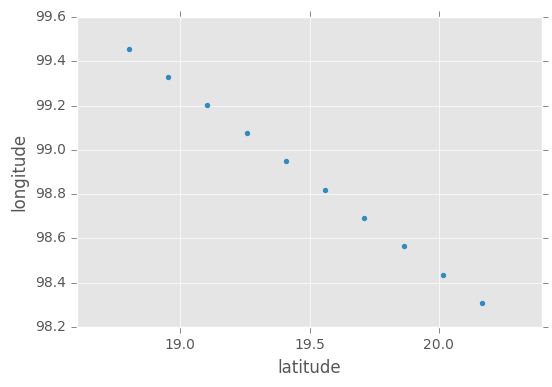

In [12]:
import matplotlib.pyplot as plt
# This next line tells jupyter to render the images inline
%matplotlib inline
plt.style.use('ggplot')
iss_position_df.plot(kind="scatter", x="latitude", y="longitude")

### Querying with Parameters

Requests can be parametrized. You can search for tweets of a specific user, for example, or [retrieve the time the ISS is over SLC](http://open-notify.org/Open-Notify-API/ISS-Pass-Times/)!

The way to query with a get request for the ISS is this:

`http://api.open-notify.org/iss-pass.json?lat=40.758701&lon=-111.876183`

We, of course, could generate that URL ourselves, but the requests library is helpful here. Since JSON is similar to dictionaries, the requests library takes dictionaries for parameters.

In [13]:
url = "http://api.open-notify.org/iss-pass.json"
coordinates = {"lat": 40.758701, "lon": -111.876183, "n":5}

r = requests.get(url, params=coordinates)
data = r.json()
data

{'message': 'success',
 'request': {'altitude': 100,
  'datetime': 1475267062,
  'latitude': 40.758701,
  'longitude': -111.876183,
  'passes': 5},
 'response': [{'duration': 459, 'risetime': 1475281692},
  {'duration': 637, 'risetime': 1475287358},
  {'duration': 595, 'risetime': 1475293185},
  {'duration': 545, 'risetime': 1475299056},
  {'duration': 597, 'risetime': 1475304876}]}

In [14]:
timestamp = data["response"][0]["risetime"]
pd.to_datetime(timestamp,  unit="s")

Timestamp('2016-10-01 00:28:12')

So, the ISS will be visible from SLC on October 1, 00:28:12 (GMT)! 

### Exercise: How many Astronouts? 

Use the [Open Notify API](http://open-notify.org/Open-Notify-API/People-In-Space/) to find out how many people are in space right now.

## Libraries and Authentication

While we now have the skills to directly talk to an API, it's sometimes a little tedious. Popular APIs often have existing Python libraries that wrap around them. [Here](https://github.com/realpython/list-of-python-api-wrappers) is a long list of wrappers! 

Now we'll explore the Twitter API using the [twython library](https://github.com/ryanmcgrath/twython). Check out the [documentation](https://twython.readthedocs.io/en/latest/).

Unfortunately, most professional APIs will require you to authenticate and will limit you in what you can do. To run the following code, you'll have to put in your own credentials (sorry - I can't share mine). 

Install twython:
`pip install twython`

* Go to https://apps.twitter.com/ and create a new app
* Save your consumer key and consumer secret in a file `credentials.py` in the format:
```python
CONSUMER_KEY = "KEY"
CONSUMER_SECRET = "KEY"
```

But before we get started, let's check out what [a tweet looks like](https://dev.twitter.com/overview/api/tweets):

```JSON
{'contributors': None,
  'coordinates': None,
  'created_at': 'Fri Sep 30 18:37:48 +0000 2016',
  'entities': {'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': []},
  'favorite_count': 2960,
  'favorited': False,
  'geo': None,
  'id': 781926033159249920,
  'id_str': '781926033159249920',
  'in_reply_to_screen_name': None,
  'in_reply_to_status_id': None,
  'in_reply_to_status_id_str': None,
  'in_reply_to_user_id': None,
  'in_reply_to_user_id_str': None,
  'is_quote_status': False,
  'lang': 'en',
  'place': None,
  'retweet_count': 1283,
  'retweeted': False,
  'source': '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>',
  'text': "For those few people knocking me for tweeting at three o'clock in the morning, at least you know I will be there, awake, to answer the call!",
  'truncated': False,
  'user': {'contributors_enabled': False,
   'created_at': 'Wed Mar 18 13:46:38 +0000 2009',
   'default_profile': False,
   'default_profile_image': False,
   'description': '',
   'entities': {'description': {'urls': []},
    'url': {'urls': [{'display_url': 'DonaldJTrump.com',
       'expanded_url': 'http://www.DonaldJTrump.com',
       'indices': [0, 23],
       'url': 'https://t.co/mZB2hymxC9'}]}},
   'favourites_count': 39,
   'follow_request_sent': None,
   'followers_count': 11929387,
   'following': None,
   'friends_count': 41,
   'geo_enabled': True,
   'has_extended_profile': False,
   'id': 25073877,
   'id_str': '25073877',
   'is_translation_enabled': True,
   'is_translator': False,
   'lang': 'en',
   'listed_count': 39225,
   'location': 'New York, NY',
   'name': 'Donald J. Trump',
   'notifications': None,
   'profile_background_color': '6D5C18',
   'profile_background_image_url': 'http://pbs.twimg.com/profile_background_images/530021613/trump_scotland__43_of_70_cc.jpg',
   'profile_background_image_url_https': 'https://pbs.twimg.com/profile_background_images/530021613/trump_scotland__43_of_70_cc.jpg',
   'profile_background_tile': True,
   'profile_banner_url': 'https://pbs.twimg.com/profile_banners/25073877/1468988952',
   'profile_image_url': 'http://pbs.twimg.com/profile_images/1980294624/DJT_Headshot_V2_normal.jpg',
   'profile_image_url_https': 'https://pbs.twimg.com/profile_images/1980294624/DJT_Headshot_V2_normal.jpg',
   'profile_link_color': '0D5B73',
   'profile_sidebar_border_color': 'BDDCAD',
   'profile_sidebar_fill_color': 'C5CEC0',
   'profile_text_color': '333333',
   'profile_use_background_image': True,
   'protected': False,
   'screen_name': 'realDonaldTrump',
   'statuses_count': 33344,
   'time_zone': 'Eastern Time (US & Canada)',
   'url': 'https://t.co/mZB2hymxC9',
   'utc_offset': -14400,
   'verified': True}
```


In [15]:
from twython import Twython
# credentials is a local file with your own credentials. It defines CONSUMER_KEY and CONSUMER_SECRET
from credentials import * 
twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET)

Here, we have created the Twython library object and authenticated against our user.

Now let's search for a hashtag:

In [16]:
tag = "#nevertrump"
result = twitter.search(q=tag)
result

{'search_metadata': {'completed_in': 0.036,
  'count': 15,
  'max_id': 781953184663240704,
  'max_id_str': '781953184663240704',
  'next_results': '?max_id=781952960834207743&q=%23nevertrump&include_entities=1',
  'query': '%23nevertrump',
  'refresh_url': '?since_id=781953184663240704&q=%23nevertrump&include_entities=1',
  'since_id': 0,
  'since_id_str': '0'},
 'statuses': [{'contributors': None,
   'coordinates': None,
   'created_at': 'Fri Sep 30 20:25:41 +0000 2016',
   'entities': {'hashtags': [{'indices': [0, 6], 'text': 'Trump'},
     {'indices': [27, 34], 'text': 'debate'},
     {'indices': [108, 119], 'text': 'NevertRUMP'}],
    'symbols': [],
    'urls': [{'display_url': 'twitter.com/brianstelter/s…',
      'expanded_url': 'https://twitter.com/brianstelter/status/781920637434601472',
      'indices': [121, 144],
      'url': 'https://t.co/TGW3tfTtXL'}],
    'user_mentions': []},
   'favorite_count': 0,
   'favorited': False,
   'geo': None,
   'id': 781953184663240704,
   'i

The result is an array of tweets, we can look at specific text:

In [17]:
result["statuses"][0]["text"]

'#Trump had nervous tics on #debate night, he sniffed, grunted, sighed, &amp; he touched the mic. ⏩He did It #NevertRUMP  https://t.co/TGW3tfTtXL'

Or print all the tweets:

In [18]:
for status in result["statuses"]:
    print(status["text"])
    print("----")

#Trump had nervous tics on #debate night, he sniffed, grunted, sighed, &amp; he touched the mic. ⏩He did It #NevertRUMP  https://t.co/TGW3tfTtXL
----
#Truth #NeverTrump #ReleaseYourReturns https://t.co/0xhpM6BE2l
----
RT @mcspocky: #MT @peterdaou
The most relevant tag of 2016: #TrumpTrashesWomen
SHAMING WOMEN IS WHAT HE DOES. #ctl #p2 #NeverTrump
https://…
----
RT @CROWENATION2016: Same woman who threatens to imprison those who speak ill about climate change!  So #NeverTrumpers #NeverTrump how's th…
----
RT @rachelmeyeryoga: Dangerous and UNACCEPTABLE. #NeverTrump #ImWithHer https://t.co/kV1uWzFNrc
----
RT @TheRickyDavila: YESSSSSSSSSSSSS! PREACH MADAME PRESIDENT! 🇺🇸❤️🇺🇸
#ImWithHer #NeverTrump #LoveTrumpsHate https://t.co/NqeF23PVuh
----
#DumpTrump #NeverTrump #LoserDonald #DropOutTrump @realDonaldTrump https://t.co/02zIo6zXLt
----
@realDonaldTrump like this source?
 #NeverTrump https://t.co/L3lTJvXvGJ
----
@feshdid @vandives @FiveThirtyEight brexit? Where are we? Wales? Not my fault i

We can also search for tweets based on usernames:

In [19]:
result = twitter.search(q="@realDonaldTrump")
for status in result["statuses"]:
    print(status["text"])
    print("----")

RT @rebelstar83: @FoxNews @gehrig38 @realDonaldTrump odd seeing Trump really isn't a conservative?
----
RT @realDonaldTrump: Using Alicia M in the debate as a paragon of virtue just shows that Crooked Hillary suffers from BAD JUDGEMENT! Hillar…
----
@politico_media @politico @debates @realDonaldTrump https://t.co/cv5Yishb5n
----
RT @realDonaldTrump: For those few people knocking me for tweeting at three o'clock in the morning, at least you know I will be there, awak…
----
@EPN algo similar se debió de decir a @realDonaldTrump
----
RT @TommyBoJack: @realDonaldTrump @TrumpForVets ... Is there really such sad lives that would piss about that? Trying hard to find somethin…
----
RT @realDonaldTrump: For those few people knocking me for tweeting at three o'clock in the morning, at least you know I will be there, awak…
----
What a sick excuse for a man, @realDonaldTrump is! https://t.co/WQchP5v6xr
----
RT @USAforTrump2016: I lost count of all the @realDonaldTrump rallies I've been to! Happy t

This returns all tweets that are mentioning a username. We can also explicitly get the tweets of a person. Let's download The Donald's last 50 tweets. [Here](https://dev.twitter.com/rest/reference/get/statuses/user_timeline) is the relevant API documentation, [here](https://github.com/ryanmcgrath/twython/blob/master/twython/endpoints.py) are the definitions for twython.

In [20]:
#twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET, ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

# count is limited to the last 3200 tweets of a user, a max of 200 per request
the_donald_result = twitter.get_user_timeline(screen_name="realDonaldTrump", count=50)
the_donald_result

[{'contributors': None,
  'coordinates': None,
  'created_at': 'Fri Sep 30 20:10:54 +0000 2016',
  'entities': {'hashtags': [{'indices': [58, 69], 'text': 'TrumpTrain'}],
   'symbols': [],
   'urls': [{'display_url': 'twitter.com/rsbnetwork/sta…',
     'expanded_url': 'https://twitter.com/rsbnetwork/status/781935134400471041',
     'indices': [70, 93],
     'url': 'https://t.co/SYuRpzosb5'}],
   'user_mentions': []},
  'favorite_count': 2635,
  'favorited': False,
  'geo': None,
  'id': 781949464152006657,
  'id_str': '781949464152006657',
  'in_reply_to_screen_name': None,
  'in_reply_to_status_id': None,
  'in_reply_to_status_id_str': None,
  'in_reply_to_user_id': None,
  'in_reply_to_user_id_str': None,
  'is_quote_status': True,
  'lang': 'en',
  'place': {'attributes': {},
   'bounding_box': {'coordinates': [[[-90.4181075, 41.696088],
      [-82.122971, 41.696088],
      [-82.122971, 48.306272],
      [-90.4181075, 48.306272]]],
    'type': 'Polygon'},
   'contained_within': [],


Let's count the numbers for The Donald's favorites and retweets.

In [21]:
the_donald_favorites = []
the_donald_retweets = []
for status in the_donald_result:
    print(status["text"])
    print(status["favorite_count"])
    print("----")
    the_donald_favorites.append(status["favorite_count"])
    the_donald_retweets.append(status["retweet_count"])

Thank you for your support - on my way now! See you soon. #TrumpTrain https://t.co/SYuRpzosb5
2635
----
Join me in Pueblo, Colorado on Monday afternoon at 3pm! #TrumpRally
https://t.co/3P3QZxzSPJ
2115
----
For those few people knocking me for tweeting at three o'clock in the morning, at least you know I will be there, awake, to answer the call!
30375
----
Why isn't Hillary 50 points ahead? Maybe it's the email scandal, policies that spread ISIS, or calling millions of… https://t.co/yKz9vCz8O1
15778
----
The people are really smart in cancelling subscriptions to the Dallas &amp; Arizona papers &amp; now USA Today will lose readers! The people get it!
23596
----
Remember, don't believe "sources said" by the VERY dishonest media. If they don't name the sources, the sources don't exist.
25813
----
Did Crooked Hillary help disgusting (check out sex tape and past) Alicia M become a U.S. citizen so she could use her in the debate?
24550
----
Using Alicia M in the debate as a paragon of virtue

Now let's do the same for Hillary.

In [22]:
hillary_results = twitter.get_user_timeline(screen_name="HillaryClinton", count=50)
hillary_results

[{'contributors': None,
  'coordinates': None,
  'created_at': 'Fri Sep 30 20:22:31 +0000 2016',
  'entities': {'hashtags': [],
   'symbols': [],
   'urls': [],
   'user_mentions': [{'id': 755024857373474816,
     'id_str': '755024857373474816',
     'indices': [3, 15],
     'name': 'Hillary en español',
     'screen_name': 'Hillary_esp'}]},
  'favorite_count': 0,
  'favorited': False,
  'geo': None,
  'id': 781952387942678528,
  'id_str': '781952387942678528',
  'in_reply_to_screen_name': None,
  'in_reply_to_status_id': None,
  'in_reply_to_status_id_str': None,
  'in_reply_to_user_id': None,
  'in_reply_to_user_id_str': None,
  'is_quote_status': False,
  'lang': 'es',
  'place': None,
  'retweet_count': 162,
  'retweeted': False,
  'retweeted_status': {'contributors': None,
   'coordinates': None,
   'created_at': 'Fri Sep 30 20:17:08 +0000 2016',
   'entities': {'hashtags': [],
    'symbols': [],
    'urls': [],
    'user_mentions': []},
   'favorite_count': 317,
   'favorited': F

In [24]:
hillary_favorites = []
hillary_retweets = []
for status in hillary_results:
    print(status["text"])
    print(status["favorite_count"])
    print("----")
    hillary_favorites.append(status["favorite_count"])
    hillary_retweets.append(status["retweet_count"])

RT @Hillary_esp: A Trump "le resulta más fácil insultar a mujeres que hablar con el presidente de México sobre construir la muralla" —Hilla…
0
----
A man who can be provoked by a tweet should not be anywhere near the nuclear codes.
2153
----
"Who gets up at 3 o'clock in the morning to engage in a Twitter attack against a former Miss Universe?” —Hillary
1793
----
"His latest Twitter meltdown is unhinged, even for him.” —Hillary on Trump
841
----
Trump "finds it a lot easier to insult women than to talk to the president of Mexico about building a wall.” —Hillary
822
----
"My view is we are already great, and if we work together, we will become even greater in the years ahead.” —Hillary in Florida
2159
----
Meet Hillary's lifelong friend, Betsy. https://t.co/KVEICHVuRL
2593
----
RT @TheDemocrats: Warning: This video contains offensive language, inappropriate behavior, and blatant misogyny. 
Voter discretion is advis…
0
----
Trump admits he "can't say" he treats women with respect. https:/

And let's create DataFrames for both of them and explore their stats:

In [25]:
donald_stats = pd.DataFrame({
        "The Donald Fav":the_donald_favorites,
        "The Donald RT":the_donald_retweets
    })

hillary_stats = pd.DataFrame({
      "Hillary Fav":hillary_favorites,
      "Hillary RT":hillary_retweets
        })

In [26]:
donald_stats.head()

,The Donald Fav,The Donald RT
0,2635,939
1,2115,733
2,30375,12053
3,15778,7787
4,23596,8173


In [27]:
donald_stats.describe()

,The Donald Fav,The Donald RT
count,50.000000,50.000000
mean,23906.440000,9525.020000
std,13730.474674,4822.023648
min,0.000000,733.000000
25%,16118.500000,6426.250000
50%,21643.000000,8666.000000
75%,32564.250000,11451.500000
max,72829.000000,26221.000000


In [28]:
hillary_stats.describe()

,Hillary Fav,Hillary RT
count,50.000000,50.000000
mean,4185.840000,2150.420000
std,5109.544779,2378.728181
min,0.000000,162.000000
25%,826.750000,513.250000
50%,1925.000000,903.500000
75%,6505.250000,2824.250000
max,20955.000000,9422.000000


Now we're plotting the tweets - but we have to sort them first so that they make sense. 

In [30]:
donald_stats = donald_stats.sort_values("The Donald Fav")
donald_stats = donald_stats.reset_index(drop=True)
donald_stats.head()

,The Donald Fav,The Donald RT
0,0,5753
1,0,9480
2,2115,733
3,2635,939
4,11200,3726


In [31]:
hillary_stats = hillary_stats.sort_values("Hillary Fav")
hillary_stats = hillary_stats.reset_index(drop=True)
hillary_stats.head()

,Hillary Fav,Hillary RT
0,0,162
1,0,497
2,0,507
3,0,366
4,0,543


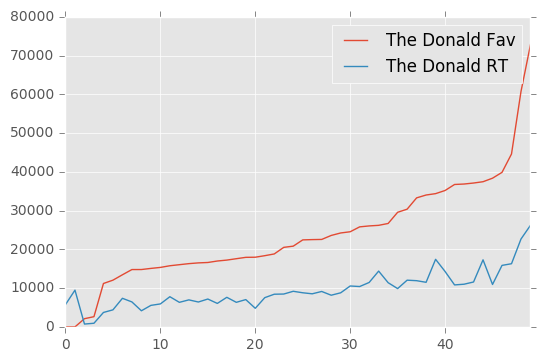

In [32]:
donald_stats.plot()

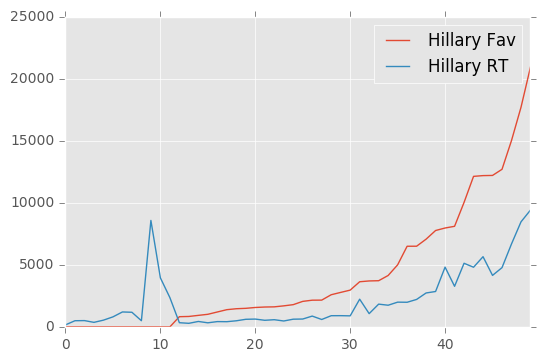

In [33]:
hillary_stats.plot()

### Exercise


Retreive the last 50 tweets with the hashtag #datavis in the SLC area, print the text and the username.